<a href="https://colab.research.google.com/github/beatrizufjf/Trabalho---Perdas-de-Larga-Escala/blob/main/Campanha_de_Medi%C3%A7%C3%A3o_Sistemas_de_Comunica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elaboração de um Modelo Log-Distância para uma ERB Celular

## Nome: Beatriz Lima de Azevedo

Este notebook detalha o procedimento para a criação de um modelo de propagação empírico do tipo log-distância para uma Estação Rádio-Base (ERB) de telefonia celular. O objetivo é, a partir de dados de potência de sinal coletados em campo, derivar um modelo matemático capaz de prever a intensidade do sinal recebido em função da distância em um ambiente específico.

A metodologia consistiu em:
* **Coleta de Dados:** Foram coletados dados de potência de sinal (RSRP em dBm) e coordenadas GPS em múltiplos pontos ao redor de uma ERB da operadora Vivo, na cidade de Juiz de Fora/MG.
* **Processamento dos Dados:** Os dados brutos foram lidos, filtrados para a tecnologia 5G, e agrupados por localização para obter medições de potência estáveis. A distância de cada ponto à ERB foi calculada.
* **Modelagem e Análise:** Foi aplicada uma regressão linear sobre os dados para determinar os parâmetros do modelo log-distância, incluindo o expoente de perda de percurso (`n`) e o desvio-padrão do sombreamento (`σ`).
* **Simulação:** Os modelos de sombreamento descorrelacionado e correlacionado foram implementados e simulados para uma comparação visual de seus comportamentos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [ ]:
# Bloco 1: Preparação e Limpeza dos Dados
# Objetivo: Ler o arquivo de log bruto, filtrar, limpar e calcular as
# distâncias para cada ponto de medição

# -- Definição de Parâmetros --

# Nome do arquivo de log exportado pelo G-NetTrack Lite com os dados coletados
nome_arquivo_bruto = 'Vivo_2025.10.05_10.40.15.txt'

# Coordenadas da ERB (torre)
erb_lat = -21.775199035114408
erb_lon = -43.372584305139384

# -- Função para Cálculo de Distância --

# Função Haversine: calcula a distância em metros entre dois pontos
# (latitude, longitude)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Raio da Terra em metros
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    meters = R * c
    return meters

# -- Processamento dos Dados --

try:
    # Ler o arquivo de dados brutos
    # sep='\t' indica que as colunas são separadas por tabulação (padrão do G-NetTrack)
    # on_bad_lines='skip' ignora qualquer linha com erro de formatação no arquivo
    df_bruto = pd.read_csv(nome_arquivo_bruto, sep='\t', on_bad_lines='skip')

    # Filtrar para manter apenas as medições da tecnologia 5G
    df_5g = df_bruto[df_bruto['NetworkTech'] == '5G'].copy()

    # Agrupar por coordenadas e calcular a potência média para cada local
    # A ideia é evitar ter múltiplos pontos no mesmo lugar, deixando os dados mais limpos
    df_agregado = df_5g.groupby(['Latitude', 'Longitude'])['Level'].mean().reset_index()

    # Calcular a distância de cada ponto único até a ERB usando a função Haversine
    df_agregado['Distancia_m'] = df_agregado.apply(
        lambda row: haversine(erb_lat, erb_lon, row['Latitude'], row['Longitude']),
        axis=1
    )

    # Criar a tabela final
    df_final = df_agregado[['Distancia_m', 'Level']].copy()
    df_final.rename(columns={'Level': 'Potencia_dBm'}, inplace=True)

    # Remover pontos com distância menor que 1 metro para evitar problemas com log(0)
    df_final = df_final[df_final['Distancia_m'] >= 1].sort_values(by='Distancia_m')

    df_final.to_csv('dados_preparados.csv', index=False)

    # -- Exibição dos Resultados --
    print(f"Total de {len(df_final)} pontos de medição únicos processados.")
    #print("\nAmostra da tabela final ('dados_preparados.csv'):")
    #print(df_final.head())
    print("\nDados salvos em 'dados_preparados.csv'.")


except FileNotFoundError:
    print(f"ERRO: O arquivo '{nome_arquivo_bruto}' não foi encontrado.")
    print("Por favor, certifique-se de que você fez o upload do arquivo para o ambiente do Colab.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

Total de 94 pontos de medição únicos processados.

Dados salvos em 'dados_preparados.csv'.


### Análise da Preparação dos Dados

O primeiro passo consistiu no tratamento dos dados brutos coletados pelo aplicativo. O código acima executou as seguintes tarefas:
* **Leitura e Filtragem:** O log de texto foi lido e filtrado para utilizar apenas as medições da tecnologia 5G, garantindo a consistência da análise.
* **Agrupamento:** Medições realizadas na mesma coordenada geográfica foram agrupadas, e a média de suas potências foi calculada. Isso resulta em um valor de sinal mais estável e representativo para cada localidade única.
* **Cálculo da Distância:** Utilizando a fórmula de Haversine e as coordenadas exatas da ERB, a distância em metros foi calculada para cada ponto de medição.

Ao final do processo, obtivemos uma tabela de dados limpa e pronta para a análise, contendo **94 pontos de medição únicos**, salva no arquivo `dados_preparados.csv`.

Gráfico 'potencia_vs_log_distancia.png' gerado.
A janela do gráfico será exibida abaixo.


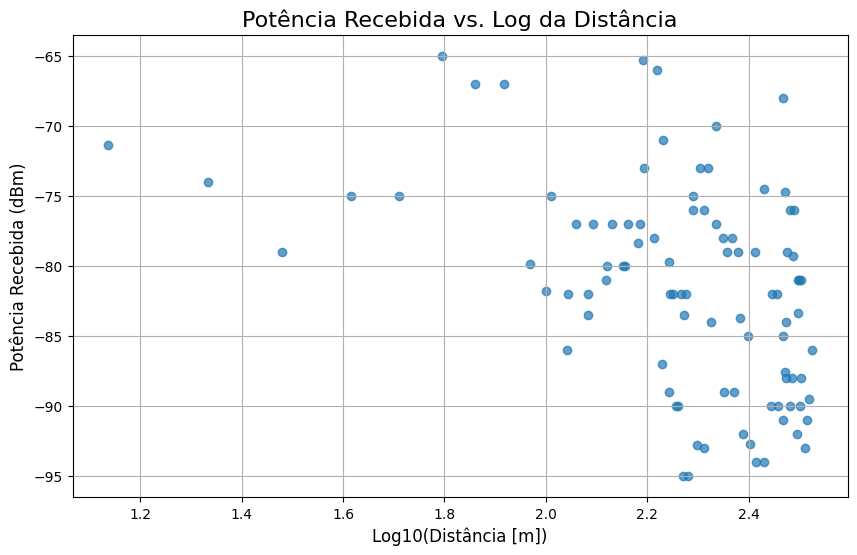

In [ ]:
# Bloco 2: Gráfico Potência Recebida vs. Log da Distância
# Objetivo: Visualizar os dados medidos em um gráfico de dispersão para observar a tendência linear

# Este código assume que o arquivo 'dados_preparados.csv' já existe no ambiente do Colab (gerado pelo Bloco 1).
try:
    data = pd.read_csv('dados_preparados.csv')

    # -- Cálculo e Plotagem --

    # Calcular o logaritmo na base 10 da distância
    data['Log_Distancia'] = np.log10(data['Distancia_m'])

    # Criar o gráfico de dispersão (scatter plot)
    plt.figure(figsize=(10, 6))
    plt.scatter(data['Log_Distancia'], data['Potencia_dBm'], alpha=0.7)

    plt.title('Potência Recebida vs. Log da Distância', fontsize=16)
    plt.xlabel('Log10(Distância [m])', fontsize=12)
    plt.ylabel('Potência Recebida (dBm)', fontsize=12)
    plt.grid(True)

    plt.savefig('potencia_vs_log_distancia.png')

    print("Gráfico 'potencia_vs_log_distancia.png' gerado.")
    print("A janela do gráfico será exibida abaixo.")

except FileNotFoundError:
    print("ERRO: O arquivo 'dados_preparados.csv' não foi encontrado.")
    print("Por favor, execute o Bloco de Código 1 primeiro para gerar este arquivo.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

### Análise Visual Inicial dos Dados

O gráfico de dispersão acima plota a Potência Recebida (dBm) em função do logaritmo na base 10 da distância. A análise visual nos permite tirar duas conclusões iniciais importantes:

1.  **Tendência de Atenuação:** Existe uma clara tendência linear decrescente. À medida que o logaritmo da distância aumenta (ou seja, o usuário se afasta da torre), a potência do sinal tende a diminuir. Isso valida o princípio fundamental da perda de percurso.
2.  **Dispersão dos Pontos (Sombreamento):** Os pontos não formam uma linha perfeita; eles estão dispersos verticalmente em torno de uma tendência central. Essa dispersão é a representação visual do fenômeno do **sombreamento (shadowing)**, causado por obstruções no ambiente (prédios, árvores, topografia) que enfraquecem o sinal de forma localizada.

m = -12.671299731287883
b = -52.83136546396953

Equação da Reta Encontrada: y = -12.67x + -52.83
O Expoente de Perda de Percurso (n) calculado é: 1.2671


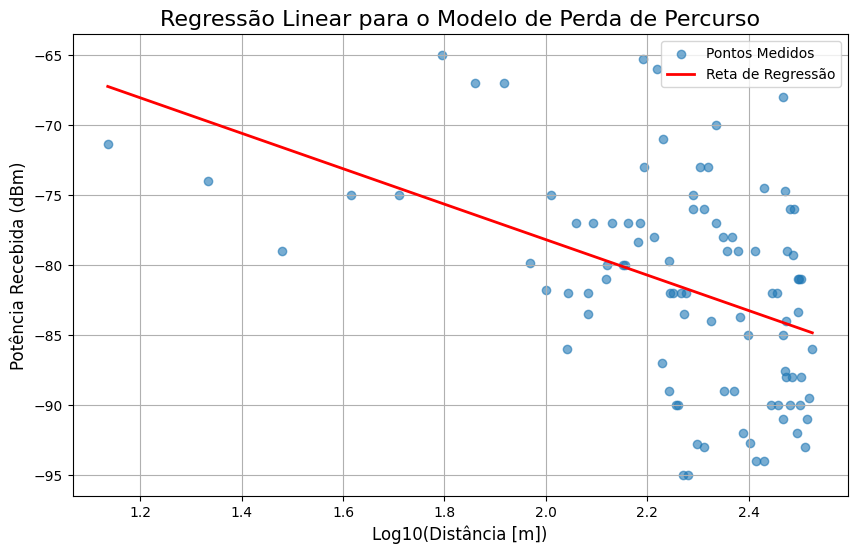

In [ ]:
# Bloco 3: Regressão Linear e Cálculo do Expoente de Perda 'n'
# Objetivo: Encontrar a reta que melhor se ajusta aos dados e, a partir
# de sua inclinação, calcular o expoente de perda de percurso 'n'

try:
    data = pd.read_csv('dados_preparados.csv')

    # Preparação dos Dados para o Modelo

    # A variável 'X' (independente) é o log da distância.
    # A variável 'y' (dependente) é a potência.
    X = np.log10(data['Distancia_m'].values).reshape(-1, 1)
    y = data['Potencia_dBm'].values
    d = data['Distancia_m'].values

    # Criação e Treinamento do Modelo

    # Inicializa o modelo de regressão linear
    model = LinearRegression()

    # Treina o modelo para encontrar a melhor reta que se ajusta aos dados X e y
    model.fit(X, y)

    # Extração dos Parâmetros e Cálculo de 'n'

    # Coeficiente angular (a inclinação da reta), que será chamado de 'm'
    m = model.coef_[0]
    # Intercepto (ponto onde a reta cruza o eixo y), que será chamado de de 'c'
    c = model.intercept_

    # O expoente de perda de percurso 'n' é calculado a partir da inclinação 'm'
    # A teoria mostra que m = -10 * n, portanto:
    n = -m / 10

    m, b = np.polyfit(np.log10(d),y,1)
    print("m =", m)
    print("b =", b)


    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, alpha=0.6, label='Pontos Medidos')
    plt.plot(X, model.predict(X), color='red', linewidth=2, label='Reta de Regressão')

    plt.title('Regressão Linear para o Modelo de Perda de Percurso', fontsize=16)
    plt.xlabel('Log10(Distância [m])', fontsize=12)
    plt.ylabel('Potência Recebida (dBm)', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.savefig('regressao_linear.png')

    print(f"\nEquação da Reta Encontrada: y = {m:.2f}x + {c:.2f}")
    print(f"O Expoente de Perda de Percurso (n) calculado é: {n:.4f}")

except FileNotFoundError:
    print("ERRO: O arquivo 'dados_preparados.csv' não foi encontrado.")
    print("Por favor, execute o Bloco de Código 1 primeiro para gerar este arquivo.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

### Análise dos Resultados da Regressão

A regressão linear traça a reta que melhor se ajusta à tendência média dos dados. A partir dos parâmetros dessa reta, definimos nosso modelo e extraímos informações sobre o ambiente de propagação.

O **expoente de perda de percurso (`n`)** calculado foi de **1.2671**. Este valor descreve a taxa com que o sinal se atenua com a distância. Para contextualizar:
* Um valor de `n = 2` é esperado em um ambiente de espaço livre, sem obstáculos.
* Valores entre `2` e `4` são comuns em áreas urbanas, onde os obstáculos atenuam o sinal mais rapidamente.

O valor encontrado (`n ≈ 1.27`) é notavelmente baixo, sugerindo que o ambiente de medição apresentou condições de propagação favoráveis, possivelmente devido ao **efeito de guia de onda (*waveguide effect*)**, onde o sinal é canalizado ao longo de corredores de ruas, sofrendo menos atenuação.

In [ ]:
# Bloco 4: Propor o Modelo Log-Distância
# Objetivo: Apresentar a equação matemática final do modelo de perda de
# percurso, com base nos parâmetros encontrados na regressão linear

# Parâmetros do Modelo (calculados no Bloco 3)
m = -12.671048730101037
c = -52.8329615598583

print(" ---- Modelo de Perda de Percurso Log-Distância ----")
print("\nCom base nos dados medidos e na análise de regressão, o modelo proposto é:")
print(f"\nPr(d) [dBm] = {m:.2f} * log10(d) + ({c:.2f})")

print("\nOnde:")
print(" -> Pr(d) é a potência recebida em dBm.")
print(" -> d é a distância da torre em metros.")

 ---- Modelo de Perda de Percurso Log-Distância ----

Com base nos dados medidos e na análise de regressão, o modelo proposto é:

Pr(d) [dBm] = -12.67 * log10(d) + (-52.83)

Onde:
 -> Pr(d) é a potência recebida em dBm.
 -> d é a distância da torre em metros.


In [ ]:
# Bloco 5: Cálculo do Desvio-Padrão do Sombreamento (Shadowing)
# Objetivo: Quantificar a dispersão dos dados em torno da reta do modelo,
# o que dá o parâmetro sigma (σ) do sombreamento

# Parâmetros do Modelo (calculados no Bloco 3)
m = -12.671048730101037
c = -52.8329615598583

try:
    data = pd.read_csv('dados_preparados.csv')

    # Cálculo do Erro

    # Para cada ponto, calcula o valor de potência que o nosso modelo PREVÊ utilizando a equação da reta: y = m*x + c
    potencia_prevista = m * np.log10(data['Distancia_m']) + c

    # erro = valor REAL medido - valor PREVISTO pelo modelo
    erro = data['Potencia_dBm'] - potencia_prevista

    # Cálculo do Desvio-Padrão
    sigma_shadowing = np.std(erro)


    print(f"O desvio-padrão (σ) para o sombreamento é: {sigma_shadowing:.4f} dB")

except FileNotFoundError:
    print("ERRO: O arquivo 'dados_preparados.csv' não foi encontrado.")
    print("Por favor, certifique-se de que o Bloco de Código 1 foi executado com sucesso.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

O desvio-padrão (σ) para o sombreamento é: 6.6514 dB


### Análise do Desvio-Padrão do Sombreamento

O desvio-padrão do sombreamento ($\sigma$) quantifica matematicamente a dispersão dos pontos em torno da reta do modelo. O valor encontrado foi de **$\sigma = 6.6514$ dB**.

Este resultado indica que, estatisticamente, a maioria das medições reais de potência está dentro de um intervalo de aproximadamente **±6.65 dB** em relação ao valor previsto pela reta do nosso modelo. É um valor típico para ambientes urbanos e suburbanos, refletindo um nível moderado de obstruções no trajeto medido.

In [ ]:
# Bloco 6: Propor os Modelos com Sombreamento (Descorrelacionado e Correlacionado)
# Objetivo: Documentar e apresentar formalmente as equações do modelo final,
# incorporando tanto a perda de percurso média quanto o efeito do sombreamento

# Parâmetros do Modelo (calculados nos Blocos 3 e 5)
m = -12.6710
c = -52.8330
sigma = 6.6514

print("="*60)
print("ITEM 8: PROPOSTA DO MODELO LOG-DISTÂNCIA COM SOMBREAMENTO")
print("="*60)

print("\nO modelo completo de propagação combina o modelo de perda média (a reta)")
print("com uma variável aleatória (Xσ) que representa o sombreamento (shadowing).")
print("\nA equação geral é: Pr(d) = Modelo_Médio + Xσ")

print("\n" + "-"*30)
print("1. Modelo com Sombreamento Descorrelacionado")
print("-"*30)
print("Este modelo assume que o efeito do sombreamento em cada ponto é independente.")
print("\nA potência recebida Pr(d) a uma distância d (metros) é dada por:")
print(f"\n    Pr(d) [dBm] = ({m:.2f} * log10(d) + ({c:.2f})) + Xσ")
print("\nOnde Xσ é uma variável aleatória Gaussiana com média 0 e desvio-padrão:")
print(f"    σ = {sigma:.4f} dB")

print("\n" + "-"*30)
print("2. Modelo com Sombreamento Correlacionado")
print("-"*30)
print("Este modelo, mais realista, assume que o efeito do sombreamento tem correlação espacial.")
print("A equação para um único ponto é a mesma, mas a variável Xσ(d) em um ponto")
print("é estatisticamente dependente dos pontos vizinhos.")
print("\nEssa correlação é descrita pela função de autocorrelação exponencial:")
print("\n    R(Δx) = σ² * exp(-|Δx| / Dc)")
print("\nOnde:")
print(f"    - σ² é a variância do sombreamento ({sigma:.4f}²).")
print("    - Δx é a distância entre dois pontos.")
print("    - Dc é a 'distância de decorrelação', um parâmetro que assumimos com um")
print("      valor típico para ambientes urbanos, por exemplo, Dc = 30 metros.")
print("="*60)

ITEM 8: PROPOSTA DO MODELO LOG-DISTÂNCIA COM SOMBREAMENTO

O modelo completo de propagação combina o modelo de perda média (a reta)
com uma variável aleatória (Xσ) que representa o sombreamento (shadowing).

A equação geral é: Pr(d) = Modelo_Médio + Xσ

------------------------------
1. Modelo com Sombreamento Descorrelacionado
------------------------------
Este modelo assume que o efeito do sombreamento em cada ponto é independente.

A potência recebida Pr(d) a uma distância d (metros) é dada por:

    Pr(d) [dBm] = (-12.67 * log10(d) + (-52.83)) + Xσ

Onde Xσ é uma variável aleatória Gaussiana com média 0 e desvio-padrão:
    σ = 6.6514 dB

------------------------------
2. Modelo com Sombreamento Correlacionado
------------------------------
Este modelo, mais realista, assume que o efeito do sombreamento tem correlação espacial.
A equação para um único ponto é a mesma, mas a variável Xσ(d) em um ponto
é estatisticamente dependente dos pontos vizinhos.

Essa correlação é descrita pe

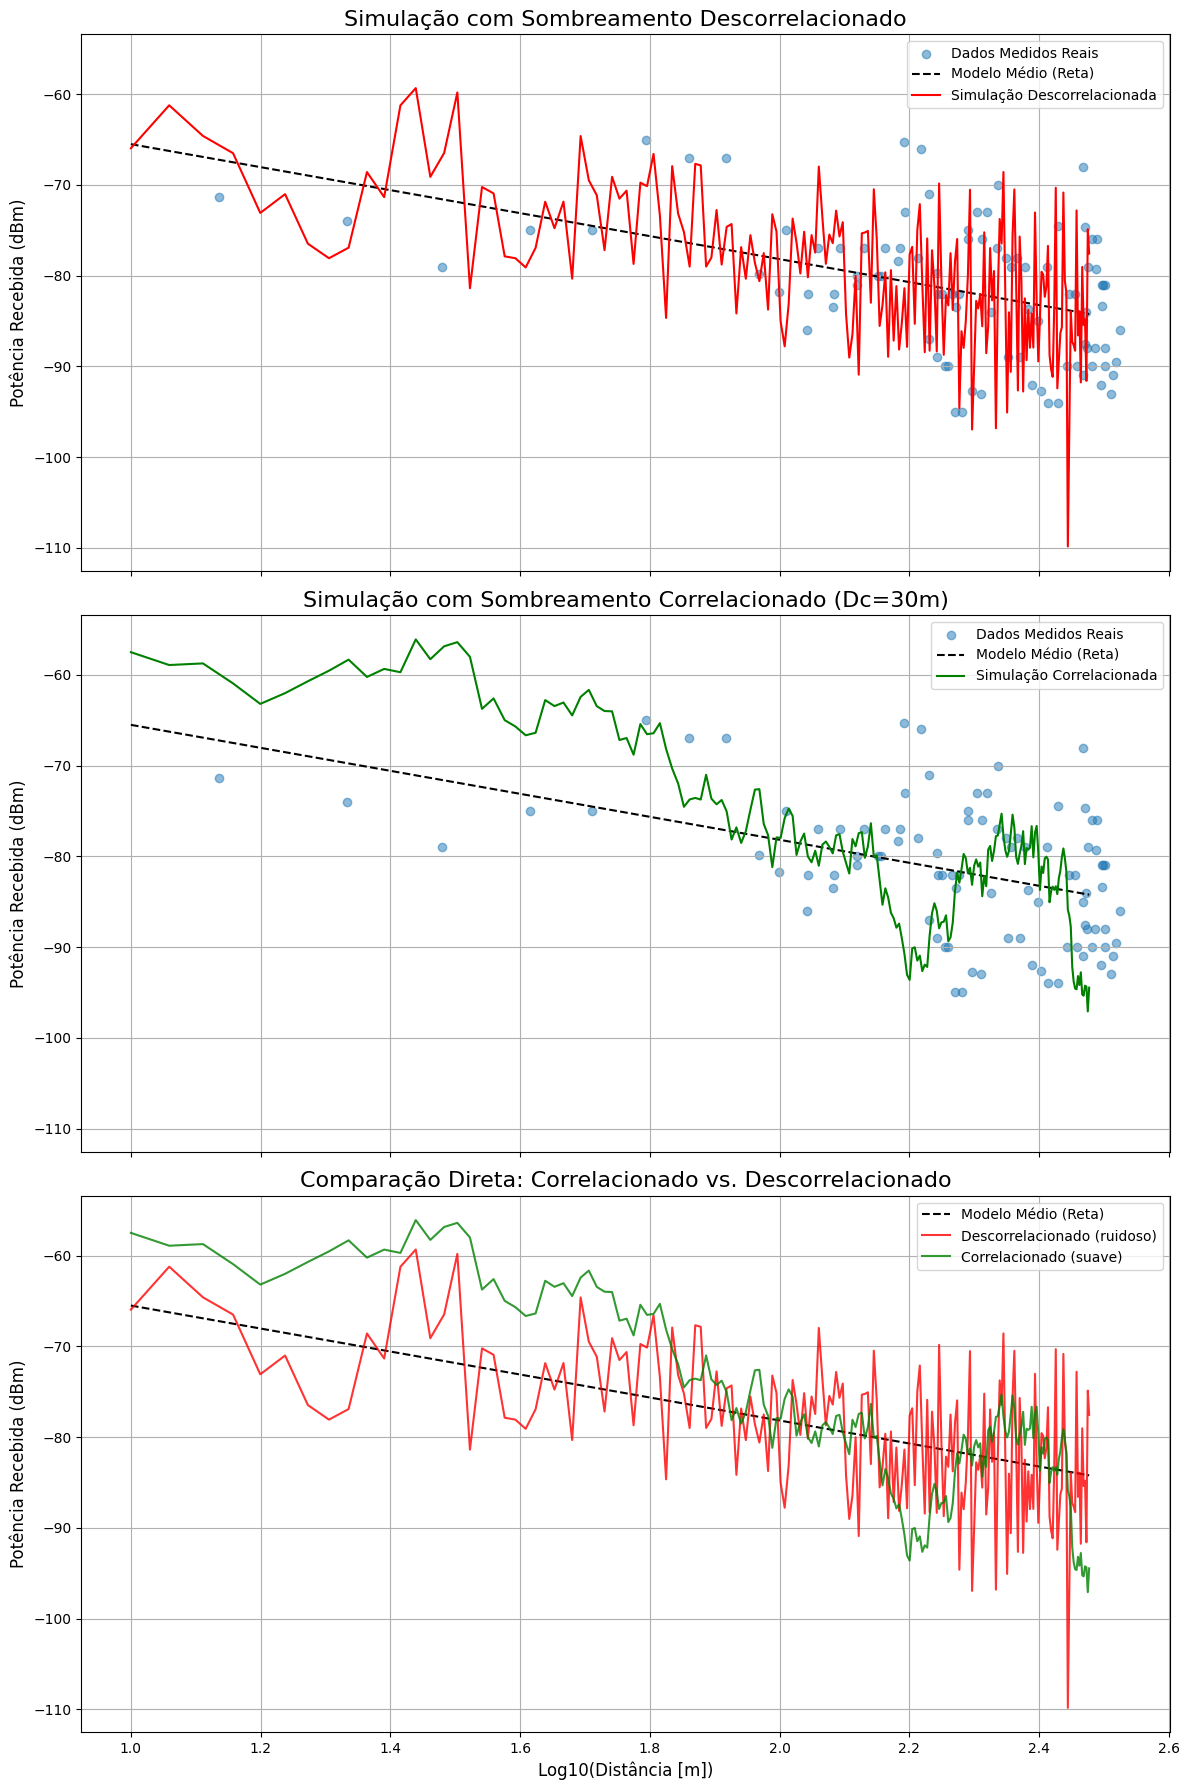

In [ ]:
# Bloco 7 (Versão Final): Geração de Dados Simulados com Gráfico Comparativo

m = -12.6710
c = -52.8330
sigma = 6.6514
n = 1.2671

# Parâmetros da Simulação
distancias_simuladas = np.linspace(10, 300, 200)
log_dist_simuladas = np.log10(distancias_simuladas)
Dc = 30  # metros

# Cálculo da Perda de Percurso Média
potencia_media_simulada = m * log_dist_simuladas + c

# Simulação do Sombreamento DESCORRELACIONADO
shadowing_descorrelacionado = np.random.normal(0, sigma, len(distancias_simuladas))
potencia_simulada_descorr = potencia_media_simulada + shadowing_descorrelacionado

# Simulação do Sombreamento CORRELACIONADO
sombra_corr = np.zeros_like(distancias_simuladas)
sombra_corr[0] = np.random.normal(0, sigma)
delta_x = distancias_simuladas[1] - distancias_simuladas[0]
correlacao = np.exp(-delta_x / Dc)
for i in range(1, len(distancias_simuladas)):
    termo_aleatorio = np.random.normal(0, sigma * np.sqrt(1 - correlacao**2))
    sombra_corr[i] = sombra_corr[i-1] * correlacao + termo_aleatorio
potencia_simulada_corr = potencia_media_simulada + sombra_corr

try:
    dados_reais = pd.read_csv('dados_preparados.csv')
    log_dist_reais = np.log10(dados_reais['Distancia_m'])

    fig, ax = plt.subplots(3, 1, figsize=(12, 18), sharex=True, sharey=True)

    # PLOT 1: Sombreamento Descorrelacionado
    ax[0].set_title('Simulação com Sombreamento Descorrelacionado', fontsize=16)
    ax[0].scatter(log_dist_reais, dados_reais['Potencia_dBm'], alpha=0.5, label='Dados Medidos Reais')
    ax[0].plot(log_dist_simuladas, potencia_media_simulada, color='black', linestyle='--', label='Modelo Médio (Reta)')
    ax[0].plot(log_dist_simuladas, potencia_simulada_descorr, color='red', label='Simulação Descorrelacionada')
    ax[0].set_ylabel('Potência Recebida (dBm)', fontsize=12)
    ax[0].legend()
    ax[0].grid(True)

    # PLOT 2: Sombreamento Correlacionado
    ax[1].set_title('Simulação com Sombreamento Correlacionado (Dc=30m)', fontsize=16)
    ax[1].scatter(log_dist_reais, dados_reais['Potencia_dBm'], alpha=0.5, label='Dados Medidos Reais')
    ax[1].plot(log_dist_simuladas, potencia_media_simulada, color='black', linestyle='--', label='Modelo Médio (Reta)')
    ax[1].plot(log_dist_simuladas, potencia_simulada_corr, color='green', label='Simulação Correlacionada')
    ax[1].set_ylabel('Potência Recebida (dBm)', fontsize=12)
    ax[1].legend()
    ax[1].grid(True)

    # PLOT 3: Comparação
    ax[2].set_title('Comparação Direta: Correlacionado vs. Descorrelacionado', fontsize=16)
    ax[2].plot(log_dist_simuladas, potencia_media_simulada, color='black', linestyle='--', label='Modelo Médio (Reta)')
    ax[2].plot(log_dist_simuladas, potencia_simulada_descorr, color='red', alpha=0.8, label='Descorrelacionado (ruidoso)')
    ax[2].plot(log_dist_simuladas, potencia_simulada_corr, color='green', alpha=0.8, label='Correlacionado (suave)')
    ax[2].set_xlabel('Log10(Distância [m])', fontsize=12)
    ax[2].set_ylabel('Potência Recebida (dBm)', fontsize=12)
    ax[2].legend()
    ax[2].grid(True)

    plt.tight_layout()
    plt.savefig('comparacao_sombreamento_completa.png')

except FileNotFoundError:
    print("ERRO: O arquivo 'dados_preparados.csv' não foi encontrado.")
    print("Por favor, execute o Bloco de Código 1 primeiro para gerar este arquivo.")

### Análise Comparativa das Simulações de Sombreamento

Os gráficos gerados simulam o comportamento dos dois modelos propostos (descorrelacionado e correlacionado). A comparação visual, especialmente no terceiro gráfico, é clara:

* **Modelo Descorrelacionado (vermelho):** Apresenta um comportamento "ruidoso" e com picos agudos. A potência do sinal varia drasticamente entre pontos próximos, o que não é fisicamente realista.
* **Modelo Correlacionado (verde):** Mostra uma variação muito mais "suave". As quedas e aumentos de sinal acontecem ao longo de distâncias maiores, formando "vales" e "picos".

Esta visualização demonstra que o **modelo de sombreamento correlacionado** é uma representação muito mais acurada do fenômeno de propagação em um ambiente real, onde os obstáculos têm dimensões físicas e seu efeito sobre o sinal é contínuo no espaço.

### Conclusão

Este trabalho realizou a criação de um modelo de propagação empírico para uma ERB 5G em Juiz de Fora/MG. A partir de medições de campo, foram derivados os parâmetros de um modelo log-distância com sombreamento log-normal.

O modelo final proposto para o ambiente medido é definido pela equação:
$$ P_r(d)_{[dBm]} = -12.67 \cdot \log_{10}(d) - 52.83 + X_{\sigma} $$

Onde $X_{\sigma}$ representa o sombreamento, modelado como uma variável aleatória gaussiana com média zero e desvio-padrão **$\sigma = 6.6514$ dB**.

O expoente de perda de percurso de **$n=1.27$** sugere um ambiente com condições de propagação favoráveis. A análise de simulação demonstrou a superioridade do modelo de sombreamento correlacionado para representar de forma realista a variação do sinal. Os resultados obtidos são coerentes e permitem uma caracterização eficaz do canal de rádio no local medido.